# Simulate the Sequences
This notebooks reads a phylogenetic tree and simulates sequences down the tree.

---
**Rule 2: Document Process, Not Just Results.** Here we describe the steps how to produce the dataset.

**Rule 3: Build a Pipeline.** This notebook describes the entire workflow, and its modularity makes it easy to change models or model parameters.

**Rule 7: Share and Explain Your Data.** To enable reproducibility we provide a `/intermediate_data` directory with files produced by the workflow.

---

## Define Sequence Simulation Parameters
The Jukes-Cantor (JC69) model [(Jukes & Cantor, 1969)](http://dx.doi.org/10.1016/B978-1-4832-3211-9.50009-7) does not have any parameters, as it assumes fully neutral sequence evolution. We will need to simulate a root sequence, so we will specify that we want a sequence of length *k* = 300 (similar to the length of *Alu* sequences).

We will also include import statements here to keep the notebook clean and organized.

In [1]:
INPUT_TREE_FILE = "./intermediate_data/dualbirth.tre"
OUTPUT_SEQUENCE_FORMAT = 'fasta'
OUTPUT_SEQUENCE_FILE = "./intermediate_data/sequences.fas"
MODEL = 'JC69'
K = 300

In [2]:
import matplotlib.pyplot as plt
from math import log
from pyvolve import Evolver,Model,Partition
from pyvolve.newick import read_tree
from random import choice
from seaborn import distplot
from treeswift import read_tree_newick

## Simulate the Root Sequence
We will be evolving a root sequence down the previously simulated phylogenetic tree, but we first need to create our root sequence. For the purposes of this notebook, we will simply randomly generate a sequence of length *k* = 300 with equal probabilities of each nucleotide.

In [3]:
root_sequence = ''.join(choice('ACGT') for _ in range(K))

## Simulate the Sequences
We will now run [Pyvolve](https://github.com/sjspielman/pyvolve) to simulate the sequences.

In [4]:
tree = read_tree(file='./intermediate_data/dualbirth.tre')
model = Model(MODEL)
partition = Partition(models=model, root_sequence=root_sequence)
evolve = Evolver(tree=tree, partitions=partition)
evolve(seqfile=OUTPUT_SEQUENCE_FILE, seqfmt=OUTPUT_SEQUENCE_FORMAT, ratefile=None, infofile=None)

## Load the Datasets
Pyvolve automatically writes the sequences to file, so we will need to load them to be able to analyze them. Also, Pyvolve loads the simulated tree in its own format, but because we will want to use more advanced features than Pyvolve's tree class allows, we will reload the tree using [TreeSwift](https://github.com/niemasd/TreeSwift).

In [5]:
def read_FASTA(filename):
    seqs = {}
    name = None
    seq = ''
    f = open(filename)
    for line in f:
        l = line.strip()
        if len(l) == 0:
            continue
        if l[0] == '>':
            if name is not None:
                assert len(seq) != 0, "Malformed FASTA"
                seqs[name] = seq
            name = l[1:]
            assert name not in seqs, "Duplicate sequence ID: %s" % name
            seq = ''
        else:
            seq += l
    f.close()
    assert name is not None and len(seq) != 0, "Malformed FASTA"
    seqs[name] = seq
    return seqs

In [6]:
sequences = read_FASTA(OUTPUT_SEQUENCE_FILE)
tree = read_tree_newick(INPUT_TREE_FILE)

## Compare Pairwise Distance Distributions
We can compare the pairwise distance distributions between the simulated datasets. Specifically, we will show the pairwise distance distribution of leaves on the simulated tree, and we will show the pairwise Hamming and JC69-corrected distributions of the simulated sequences.

For two sequences $u,v$ with true JC69 distance $d(u,v)$, the Hamming distance $h(u,v)$ is expected to be *at most* equal to $d(u,v)$, but as $d(u,v)$ increases, $h(u,v)$ will deviate further and further from $d(u,v)$. Specifically, the following relation holds in expectation:

$h(u,v) = \frac{3\left(1+e^{-\frac{4d(u,v)}{3}}\right)}{4}$

This is because, any time an already-mutated site mutates again, the JC69 distance increases, but this second mutation is unobservable to us, so the Hamming distance does not change. An intuitive way to help internalize this phenomenon is to realize that, by definition, the theoretical maximum possible Hamming distance between two sequences is exactly 100%, whereas JC69 distance is theoretically unbounded. This relation allows for a simple correction of Hamming distances to JC69:

$d(u,v) = -\frac{3}{4}\ln\left(1-\frac{4h(u,v)}{3}\right)$

In [7]:
def compute_tree_distances(tree):
    dm = tree.distance_matrix()
    keys = list(dm.keys())
    return [dm[keys[i]][keys[j]] for i in range(len(keys)-1) for j in range(i+1,len(keys))]

In [8]:
def hamming(u,v):
    return sum(u[i] != v[i] for i in range(len(u)))/float(len(u))

In [9]:
def compute_hamming_distances(sequences):
    keys = list(sequences.keys())
    return [hamming(sequences[keys[i]], sequences[keys[j]]) for i in range(len(keys)-1) for j in range(i+1,len(keys))]

In [10]:
def jc69_correction(h):
    return -3*log(1-(4*h/3))/4

In [11]:
pairwise_distances = dict()
pairwise_distances['Tree'] = compute_tree_distances(tree)
pairwise_distances['Hamming'] = compute_hamming_distances(sequences)
pairwise_distances['Jukes-Cantor 69 (JC69)'] = [jc69_correction(h) for h in pairwise_distances['Hamming']]

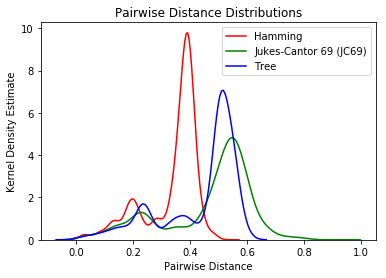

In [12]:
colors = {'Tree':'blue', 'Hamming':'red', 'Jukes-Cantor 69 (JC69)':'green'}
for k in sorted(pairwise_distances.keys()):
    distplot(pairwise_distances[k], kde=True, hist=False, color=colors[k], label=k);
plt.title("Pairwise Distance Distributions");
plt.xlabel("Pairwise Distance");
plt.ylabel("Kernel Density Estimate");

In [13]:
for k in sorted(pairwise_distances.keys()):
    print("Average Pairwise %s Distance: %f" % (k, sum(pairwise_distances[k])/float(len(pairwise_distances[k]))))

Average Pairwise Hamming Distance: 0.336708
Average Pairwise Jukes-Cantor 69 (JC69) Distance: 0.464744
Average Pairwise Tree Distance: 0.434832


---

**Author:** [Niema Moshiri](https://niema.net/), UC San Diego, October 2, 2018

---